# Question 5

Do certain product categories have significantly higher/lower total order prices? 

After looking at the initial data, I decided to focus on Meat/Poultry. 

Do Meat/Poultry products have a statistically significant effect on total order price?

Confections       
Beverages         
Seafood           
Condiments        
Dairy Products    
Grains/Cereals     
Meat/Poultry       
Produce

In [1]:
#import libraries
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

#For tukey test
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

#For KS Test
from scipy import stats

#For Sampling, Welch's T-Test, Cohen's d - flatiron_stats.py. I have updated with my own functions.
from flatiron_stats import p_value_welch_ttest, welch_t, cohens_d, get_sampling_means

#For SQL Helpter functions
from flatiron_sql import view_table, get_table, get_table_names

#For Power Analysis
from statsmodels.stats.power import TTestIndPower, TTestPower

#significance level
alpha = 0.05

In [2]:
#connect to the Northwind database
conn = sqlite3.connect("Northwind_small.sqlite")

### Data Query:

I need to get OrderId, Unit Price, Quantity, ProductName, CategoryName

Tables: Product, Category, OrderDetail, Order

In [3]:
query = """SELECT od.OrderId, od.UnitPrice, od.Quantity, 
                  od.UnitPrice * od.Quantity * (1-od.Discount) AS TotalOrderPrice, 
                  ProductName, CategoryName
           FROM 
           'Order' o 
           JOIN OrderDetail od ON o.Id=od.OrderId
           JOIN Product p ON p.Id=od.ProductId
           JOIN Category c ON c.Id=p.CategoryId
           
           """
df = pd.read_sql(query,conn)
df.head()

,OrderId,UnitPrice,Quantity,TotalOrderPrice,ProductName,CategoryName
0,10248,14.0,12,168.0,Queso Cabrales,Dairy Products
1,10248,9.8,10,98.0,Singaporean Hokkien Fried Mee,Grains/Cereals
2,10248,34.8,5,174.0,Mozzarella di Giovanni,Dairy Products
3,10249,18.6,9,167.4,Tofu,Produce
4,10249,42.4,40,1696.0,Manjimup Dried Apples,Produce


### Summary Stats

In [4]:
df.CategoryName.value_counts()

Beverages         404
Dairy Products    366
Confections       334
Seafood           330
Condiments        216
Grains/Cereals    196
Meat/Poultry      173
Produce           136
Name: CategoryName, dtype: int64

In [5]:
grouped_df = df.groupby(['CategoryName'])
grouped_df = pd.DataFrame(grouped_df.TotalOrderPrice.mean())
grouped_df = grouped_df.reset_index()

Show average Total Order Price by category

In [6]:
grouped_df.columns = ['CategoryName','Average Order Price']
grouped_df

,CategoryName,Average Order Price
0,Beverages,663.040050
1,Condiments,490.958727
2,Confections,501.069536
3,Dairy Products,640.730287
4,Grains/Cereals,488.492793
5,Meat/Poultry,942.325777
6,Produce,735.180735
7,Seafood,397.762841


## Visualize the Data

Text(0, 0.5, 'Total Order Price')

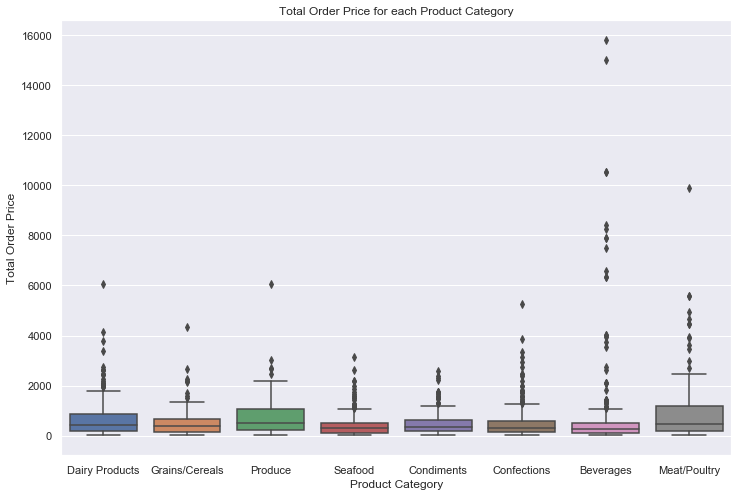

In [7]:
sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x='CategoryName',y='TotalOrderPrice',data=df)
plt.title('Total Order Price for each Product Category')
plt.xlabel('Product Category');
plt.ylabel('Total Order Price')

Remove Outliers - order price > 5000

In [8]:
df = df[df.TotalOrderPrice<5000]

Text(0, 0.5, 'Total Order Price')

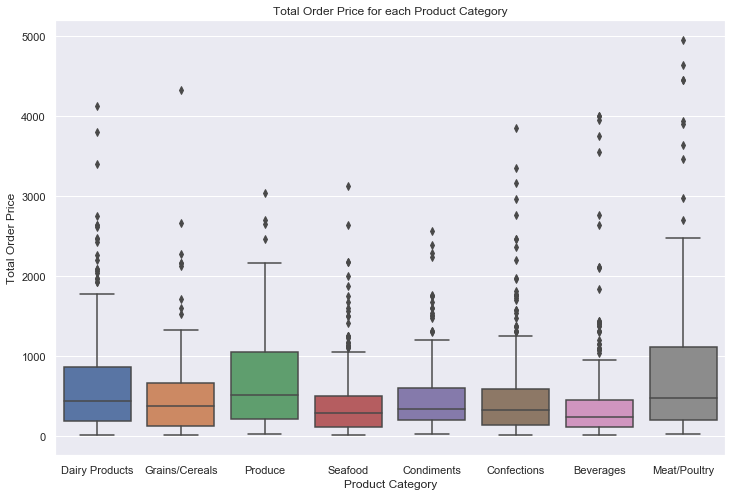

In [9]:
sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x='CategoryName',y='TotalOrderPrice',data=df)
plt.title('Total Order Price for each Product Category')
plt.xlabel('Product Category');
plt.ylabel('Total Order Price')

## Hypothesis

**Ho:** There is no statistical difference in Total Order Price for Meat/Poultry.

**Ha:** The total order price will be statistically different for Meat/Poultry vs other product categories.

## Histogram for each category
Total Order Price by category

In [10]:
category_names = list(df.CategoryName.unique())
category_names

['Dairy Products',
 'Grains/Cereals',
 'Produce',
 'Seafood',
 'Condiments',
 'Confections',
 'Beverages',
 'Meat/Poultry']

/Users/dennistrimarchi/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


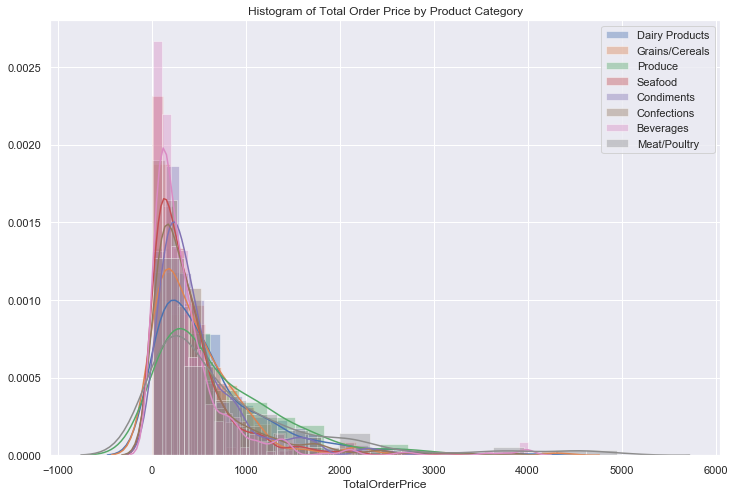

In [11]:
sns.set(rc={'figure.figsize':(12,8)})
for category in category_names:
    sns.distplot(df.TotalOrderPrice[df.CategoryName==category], label=category)
plt.title('Histogram of Total Order Price by Product Category')
plt.legend()

## ANOVA Test

In [12]:
#ANOVA TEST
formula = "TotalOrderPrice ~ C(CategoryName)"
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
table['reject_null'] = table['PR(>F)'] < alpha
print(table)

                       sum_sq      df          F        PR(>F)  reject_null
C(CategoryName)  3.648664e+07     7.0  14.904216  4.220117e-19         True
Residual         7.445646e+08  2129.0        NaN           NaN        False


## Tukey Test
Pairwise comparison

In [13]:
#TUKEY TEST
mc = MultiComparison(df['TotalOrderPrice'], df['CategoryName'])
result = mc.tukeyhsd(alpha=alpha)
print("Groups are Product Categories, summary stats are Total Order Price\n")
#Convert result to dataframe for prettiness and to only show the comparisons that include no-discount
tukey_df = pd.DataFrame(data=result._results_table.data[1:], columns=result._results_table.data[0])
print("Multiple Comparison of Means - Tukey HSD,FWER=0.05")
tukey_df

Groups are Product Categories, summary stats are Total Order Price

Multiple Comparison of Means - Tukey HSD,FWER=0.05


,group1,group2,meandiff,lower,upper,reject
0,Beverages,Condiments,91.1932,-60.8422,243.2287,False
1,Beverages,Confections,86.9889,-46.7220,220.6999,False
2,Beverages,Dairy Products,226.1449,95.6416,356.6482,True
3,Beverages,Grains/Cereals,88.7273,-68.2297,245.6843,False
4,Beverages,Meat/Poultry,435.3996,270.6351,600.1641,True
5,Beverages,Produce,296.1055,117.0620,475.1489,True
6,Beverages,Seafood,-2.0026,-136.0418,132.0365,False
7,Condiments,Confections,-4.2043,-160.9516,152.5431,False
8,Condiments,Dairy Products,134.9516,-19.0686,288.9719,False
9,Condiments,Grains/Cereals,-2.4659,-179.4592,174.5273,False


Seems to be a difference between short shelf life and long shelf life product categories.

Seafood seems to be the one that doesn't make sense as it has lower order price. Will investigate.

Meat/Poultry is statistically different from every category except for Produce.

### Look at Tukey results for Meat/Poultry Only

In [14]:
meat_poultry_tukey = tukey_df[(tukey_df.group1=='Meat/Poultry')|(tukey_df.group2=='Meat/Poultry')]
meat_poultry_tukey

,group1,group2,meandiff,lower,upper,reject
4,Beverages,Meat/Poultry,435.3996,270.6351,600.1641,True
10,Condiments,Meat/Poultry,344.2063,160.2540,528.1587,True
15,Confections,Meat/Poultry,348.4106,179.2885,517.5328,True
19,Dairy Products,Meat/Poultry,209.2547,42.6570,375.8524,True
22,Grains/Cereals,Meat/Poultry,346.6723,158.6319,534.7126,True
25,Meat/Poultry,Produce,-139.2941,-346.1279,67.5398,False
26,Meat/Poultry,Seafood,-437.4022,-606.7840,-268.0205,True


## Effect Size

In [15]:
meat_poultry = df.TotalOrderPrice[df.CategoryName=='Meat/Poultry']
category_names = ['Beverages', 'Condiments', 'Confections', 'Dairy Products', 'Grains/Cereals', 'Produce','Seafood']

In [16]:
effect_sizes = []
print('Effect Size with Meat/Poultry')
for category in category_names:
    d = cohens_d(meat_poultry,df.TotalOrderPrice[df.CategoryName==category])
    print(f"{category}: d= {d}")
    effect_sizes.append(round(d,3))

Effect Size with Meat/Poultry
Beverages: d= 0.6129681232712014
Condiments: d= 0.46535979260903443
Confections: d= 0.475807233793337
Dairy Products: d= 0.27463577207341566
Grains/Cereals: d= 0.44664218343093204
Produce: d= 0.16515903352226594
Seafood: d= 0.6523691882089625


Append to end of Tukey dataframe for prettiness

In [17]:
meat_poultry_tukey['Effect Size'] = effect_sizes
meat_poultry_tukey

/Users/dennistrimarchi/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,group1,group2,meandiff,lower,upper,reject,Effect Size
4,Beverages,Meat/Poultry,435.3996,270.6351,600.1641,True,0.613
10,Condiments,Meat/Poultry,344.2063,160.2540,528.1587,True,0.465
15,Confections,Meat/Poultry,348.4106,179.2885,517.5328,True,0.476
19,Dairy Products,Meat/Poultry,209.2547,42.6570,375.8524,True,0.275
22,Grains/Cereals,Meat/Poultry,346.6723,158.6319,534.7126,True,0.447
25,Meat/Poultry,Produce,-139.2941,-346.1279,67.5398,False,0.165
26,Meat/Poultry,Seafood,-437.4022,-606.7840,-268.0205,True,0.652


## Summary / Conclusion

Meat/Poultry has a statistically higher average order price than every other product category with the exception of Produce.

Meat/Poultry has the largest effect difference from Beverages and Seafood categories.

## Recommendations

Meat/Poultry bring in higher revenue per order. More bang for your buck.